In [1]:
#############################
## Load necessary packages ##
#############################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.optimize as opt
import os

In [2]:
####################
## Importing Data ##
####################
# Construct the file path
desktop_path = os.path.expanduser('~/Desktop')
file_path = os.path.join(desktop_path, 'mev_research', 'mev_data', 'mev_2023_q1_cleaned.csv')
# Load the CSV file into a pandas DataFrame
mev_2023_q1_cleaned = pd.read_csv(file_path)
print(mev_2023_q1_cleaned.head())

   block_number                                         block_hash  \
0      16310003  0x21407af173d491c0fdb0d21139a1e3f7245805b83fb4...   
1      16310004  0x608ef658a32408b9f532bb1832cbc98a26a63886b660...   
2      16310005  0x984abdc43b4aff7563b5363c27d341cfd21a66d7927d...   
3      16310006  0x1fecfff5e96eae1a166392f8ff2e5ec05f56057b7a10...   
4      16310007  0xaf019799adcef6b1b1d4217a5371acfd24764db17911...   

   block_timestamp                        header_fee_recipient  \
0       1672553039  0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5   
1       1672553051  0xfeebabe6b0418ec13b30aadf129f5dcdd4f70cea   
2       1672553063  0x4675c7e5baafbffbca748158becba61ef3b0a263   
3       1672553075  0x690b9a9e9aa1c9db991c7721a92d351db4fac990   
4       1672553087  0xf2f5c73fa04406b1995e397b55c24ab1f3ea726c   

                      validator_fee_recipient  \
0  0x388c818ca8b9251b393131c08a736a67ccb19297   
1  0x86c9ee9d8ba417d5c330fc8f68503b616b628b6d   
2  0x4675c7e5baafbffbca748158becba6

In [3]:
###############################################
## Split data into training and testing sets ##
###############################################
# Determine the split index
split_index = int(len(mev_2023_q1_cleaned) * 0.8)

# Split the data into training and testing sets based on the sequence
train_data = mev_2023_q1_cleaned[:split_index]
test_data = mev_2023_q1_cleaned[split_index:]

# Display the shapes of the resulting datasets
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Save the splits to new CSV files
train_data.to_csv('mev_2023_q1_train.csv', index=False)
test_data.to_csv('mev_2023_q1_test.csv', index=False)

# Display the first few rows of the dataset
# Read the training dataset
mev_2023_q1_train = pd.read_csv('mev_2023_q1_train.csv')
# Read the testing dataset
mev_2023_q1_test = pd.read_csv('mev_2023_q1_test.csv')

# Print the training dataset
print(mev_2023_q1_train.head())
# Print the testing dataset
print(mev_2023_q1_test.head())

# Load the train data
log_returns_train = mev_2023_q1_train['log_return'].values
actual_prices_train = mev_2023_q1_train['proposer_total_reward_in_eth'].values
log_prices_train = np.log(actual_prices_train)

# Load the test data
log_returns_test = mev_2023_q1_test['log_return'].values
actual_prices_test = mev_2023_q1_test['proposer_total_reward_in_eth'].values
log_prices_test = np.log(actual_prices_test)

# Check Log Transition Train
print("len of train_actual_price:", len(actual_prices_train))  # Number of train actual price
print("len of train_log_price:", len(log_prices_train))  # Number of train log price
print("mean of train_actual_price:", np.mean(actual_prices_train))  # mean of train actual price
print("mean of train_log_price:", np.mean(log_prices_train))  # mean of train log price

# Check Log Transition Test
print("len of test_actual_price:", len(actual_prices_test))  # Number of test actual price
print("len of test_log_price:", len(log_prices_test))  # Number of test log price
print("mean of test_actual_price:", np.mean(actual_prices_test))  # mean of test actual price
print("mean of test_log_price:", np.mean(log_prices_test))  # mean of test log price

Training data shape: (511677, 18)
Testing data shape: (127920, 18)
   block_number                                         block_hash  \
0      16310003  0x21407af173d491c0fdb0d21139a1e3f7245805b83fb4...   
1      16310004  0x608ef658a32408b9f532bb1832cbc98a26a63886b660...   
2      16310005  0x984abdc43b4aff7563b5363c27d341cfd21a66d7927d...   
3      16310006  0x1fecfff5e96eae1a166392f8ff2e5ec05f56057b7a10...   
4      16310007  0xaf019799adcef6b1b1d4217a5371acfd24764db17911...   

   block_timestamp                        header_fee_recipient  \
0       1672553039  0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5   
1       1672553051  0xfeebabe6b0418ec13b30aadf129f5dcdd4f70cea   
2       1672553063  0x4675c7e5baafbffbca748158becba61ef3b0a263   
3       1672553075  0x690b9a9e9aa1c9db991c7721a92d351db4fac990   
4       1672553087  0xf2f5c73fa04406b1995e397b55c24ab1f3ea726c   

                      validator_fee_recipient  \
0  0x388c818ca8b9251b393131c08a736a67ccb19297   
1  0x86c9ee9d8ba4

In [4]:
#############################################
## Find Initial Parameters Value 32 Slots ##
#############################################
# Define window size
window_size = 32
# Calculate block variance
block_variances_32blocks = [log_returns_train[i:i+window_size].var() for i in range(0, len(log_returns_train), window_size) if i+window_size <= len(log_returns_train)]
# Convert to Series for further analysis
rolling_variance_32slots = pd.Series(block_variances_32blocks)
# Define dt
dt = 1/82125 # in years

# Find Kappa 
def estimate_kappa(rolling_variance, dt):
    log_variance = np.log(rolling_variance)
    autocorr = np.corrcoef(log_variance[:-1], log_variance[1:])[0, 1]
    kappa = -np.log(autocorr) / dt
    return kappa

initial_kappa = estimate_kappa(rolling_variance_32slots, dt)
print("Initial kappa is: ", initial_kappa)

# Find Sigma 
def estimate_sigma(rolling_variance, dt):
    log_variance = np.log(rolling_variance)
    diff_log_variance = np.diff(log_variance)
    sigma = np.sqrt(np.var(diff_log_variance) / dt)
    return sigma

initial_sigma = estimate_sigma(rolling_variance_32slots, dt)
print("Initial sigma is: ", initial_sigma)

# Estimate initial Mu
initial_mu = np.mean(log_returns_train)
print("Initial mu is: ", initial_mu)

# Estimate initial theta
initial_theta = np.var(log_returns_train)
print("Initial theta is: ", initial_theta)

# Estimate initial jump parameters (lambda_j, mu_j, sigma_j)
def estimate_jump_params(log_prices, window_size, dt, threshold_multiplier=1.5):
    # Calculate the log price changes
    diff_log_prices = np.diff(log_prices)
    
    # Define the threshold
    threshold = threshold_multiplier * np.std(diff_log_prices)
    
    # Identify jumps as changes in log prices that exceed the threshold
    jump_indices = np.where(np.abs(diff_log_prices) > threshold)[0]
    
    # Estimate jump intensity lambda_j (Poisson parameter) per unit time dt
    jump_intensity = len(jump_indices) / len(log_prices) 
    
    # Estimate jump size mu_j as the average of significant jumps (those above the threshold)
    significant_jumps = diff_log_prices[jump_indices]
    jump_size = np.mean(significant_jumps)
    
    # Estimate jump volatility sigma_j as the standard deviation of significant jumps
    jump_volatility = np.std(significant_jumps)
    
    return jump_size, jump_intensity, jump_volatility

# Find Jump Size, Lambda, and Sigma_j
initial_mu_j, initial_lambda_j, initial_sigma_j = estimate_jump_params(log_prices_train, window_size, dt)
print("Initial jump size (mu_j) is: ", initial_mu_j)
print("Initial jump intensity (lambda_j) is: ", initial_lambda_j)
print("Initial jump volatility (sigma_j) is: ", initial_sigma_j)

def estimate_variance_jump_params(rolling_variance, dt, threshold_percentile=90):
    # Calculate the changes in variance
    diff_variance = np.diff(rolling_variance)
    
    # Define the threshold for jumps in variance based on the empirical distribution
    threshold = np.percentile(np.abs(diff_variance), threshold_percentile)

    # Identify jumps as changes in variance that exceed the threshold
    jump_indices = np.where(np.abs(diff_variance) > threshold)[0]
    
    # Estimate jump intensity lambda_j_v (Poisson parameter) per unit time dt
    jump_intensity_v = len(jump_indices) / len(rolling_variance)
    
    # Estimate jump size mu_j_v using a log-normal approach to ensure positive values
    significant_jumps_v = diff_variance[jump_indices]
    jump_size_v = np.median(np.log(np.abs(significant_jumps_v) + 1))
    
    # Estimate jump volatility sigma_j_v as the standard deviation of log-jump sizes
    log_jumps = np.log(np.abs(significant_jumps_v) + 1)
    jump_volatility_v = np.std(log_jumps)
    
    return jump_size_v, jump_intensity_v, jump_volatility_v, threshold

# Find Jump Size, Lambda, and Sigma_j for variance
initial_mu_j_v, initial_lambda_j_v, initial_sigma_j_v, threshold = estimate_variance_jump_params(rolling_variance_32slots, dt, threshold_percentile=90)
print("Initial variance jump size (mu_j_v) is: ", initial_mu_j_v)
print("Initial variance jump intensity (lambda_j_v) is: ", initial_lambda_j_v)
print("Initial variance jump volatility (sigma_j_v) is: ", initial_sigma_j_v)

Initial kappa is:  142507.37886693285
Initial sigma is:  206.45423643820405
Initial mu is:  -4.1655358788419694e-07
Initial theta is:  1.7941995110032327
Initial jump size (mu_j) is:  0.36091714626793653
Initial jump intensity (lambda_j) is:  0.11808426018757927
Initial jump volatility (sigma_j) is:  3.1172813186272053
Initial variance jump size (mu_j_v) is:  1.2859993313391311
Initial variance jump intensity (lambda_j_v) is:  0.10000625429983113
Initial variance jump volatility (sigma_j_v) is:  0.17746033377322543


In [5]:
#########################################
## Log Likelihood Estimation 32 Slots ##
#########################################
def bates_log_likelihood(params, log_prices):
    mu, kappa, theta, sigma, rho, lambda_j, mu_j, sigma_j, lambda_j_v, mu_j_v, sigma_j_v  = params
    n = len(log_prices)
    dt = 1/82125

    # Initialize the variance and log-likelihood
    v = np.var(np.diff(log_prices))  # Initial variance estimate
    log_likelihood = 0
    
    # Generate correlated Brownian motions
    dW = np.random.multivariate_normal([0, 0], [[1, rho], [rho, 1]], n - 1) * np.sqrt(dt)
    dW1, dW2 = dW[:, 0], dW[:, 1]
    
    for i in range(1, n):
        # Simplified jump component: Additive jumps directly to the log price
        dN_v = np.random.poisson(lambda_j_v * dt)  # Number of jumps in the interval
        if dN_v > 0:
            J_v = np.sum(np.random.normal(mu_j_v, sigma_j_v, dN_v))  # Simplified additive jumps
        else:
            J_v = 0
        
        v_next = max(0, v) + kappa * (theta - max(0, v)) * dt + sigma * np.sqrt(max(0, v)) * dW2[i - 1] + J_v
        
        # Simplified jump component: Additive jumps directly to the log price
        dN = np.random.poisson(lambda_j * dt)  # Number of jumps in the interval
        if dN > 0:
            J = np.sum(np.random.normal(mu_j, sigma_j, dN))  # Simplified additive jumps
        else:
            J = 0
        
        dY = (mu - 0.5 * max(0, v)) * dt + np.sqrt(max(0, v)) * dW1[i - 1] + J
        
        # Update log-likelihood
        log_likelihood += -0.5 * (np.log(2 * np.pi * max(0.0001, v)) + (log_prices[i] - log_prices[i - 1] - dY) ** 2 / max(0.0001, v))
        v = v_next

    return -log_likelihood

def optimize_parameters(log_prices):
    # Define bounds and initial guesses
    bounds = [(None, None), (0, None), (0, None), (0, None), (-1, 1), (0, None), (None, None), (0, None), (0, None), (None, None), (0, None)]
    initial_guess = [initial_mu, initial_kappa, initial_theta, initial_sigma, 0, initial_lambda_j, initial_mu_j, initial_sigma_j, initial_lambda_j_v, initial_mu_j_v, initial_sigma_j_v]

    # Minimize the negative log likelihood
    result = opt.minimize(bates_log_likelihood, initial_guess, args=(log_prices), bounds=bounds)

    return result.x

optimized_params = optimize_parameters(log_prices_train)
print("Adjusted parameters:", optimized_params)

estimated_mu, estimated_kappa, estimated_theta, estimated_sigma, estimated_rho, estimated_lambda_j, estimated_mu_j, estimated_sigma_j, estimated_lambda_j_v, estimated_mu_j_v, estimated_sigma_j_v = optimized_params

Adjusted parameters: [-1.32017287e-06  1.42507379e+05  1.79419951e+00  2.06454238e+02
 -2.80432875e-21  1.18084260e-01  3.60917575e-01  3.11728346e+00
  1.00006254e-01  1.28599698e+00  1.77460838e-01]


In [6]:
#####################################
## Monte Carlo Simulation 32 Slots ##
#####################################
T = 18 / 365  # Total time in years for simulation (18 days)
dt = 1 / 82125  # Delta t in years per epoch
num_paths = 1000  # Number of Monte Carlo paths
N = 4048  # Total number of time steps (Per Epoch)

# Initial conditions
S0 = np.median(log_prices_train)  # Start from the median log price in the train dataset
v0 = np.var(log_returns_train)  # Initial variance, estimated from the train log returns

# Arrays to store simulations
S = np.zeros((N, num_paths))
v = np.zeros((N, num_paths))

S[0, :] = S0
v[0, :] = v0

# Generate correlated random shocks for each path
for path in range(num_paths):
    dW = np.random.multivariate_normal([0, 0], [[1, estimated_rho], [estimated_rho, 1]], N) * np.sqrt(dt)
    dW1, dW2 = dW[:, 0], dW[:, 1]

    for i in range(1, N):

        dN_v= np.random.poisson(estimated_lambda_j_v)  # Number of jumps in the interval
        if dN_v > 0:
            J_v = np.sum(np.exp(np.random.normal(estimated_mu_j_v, estimated_sigma_j_v, dN_v))-1)  # Simplified additive jumps
        else:
            J_v = 0

        v_prev = v[i - 1, path]
        v_drift = estimated_kappa * (estimated_theta - max(v_prev, 0)) * dt
        v_diffusion = estimated_sigma * np.sqrt(max(v_prev, 0)) * dW2[i - 1]
        
        # Calculate the variance before adding jumps to ensure it's non-negative
        v_next = np.abs(v_prev + v_drift + v_diffusion)

        # Add the jump component, ensuring variance remains non-negative
        v[i, path] = np.abs(v_next + J_v)
        

        dN = np.random.poisson(estimated_lambda_j * dt)  # Number of jumps in the interval
        if dN > 0:
            J = np.sum(np.random.normal(estimated_mu_j, estimated_sigma_j, dN))  # Simplified additive jumps
        else:
            J = 0
        
        # Update log price with drift, diffusion, and jump components
        S[i, path] = S[i - 1, path] + (estimated_mu - 0.5 * max(v[i, path], 0)) * dt + np.sqrt(max(v[i, path], 0)) * dW1[i - 1] + J

print("Shape of v:", v.shape)

Shape of v: (4048, 1000)


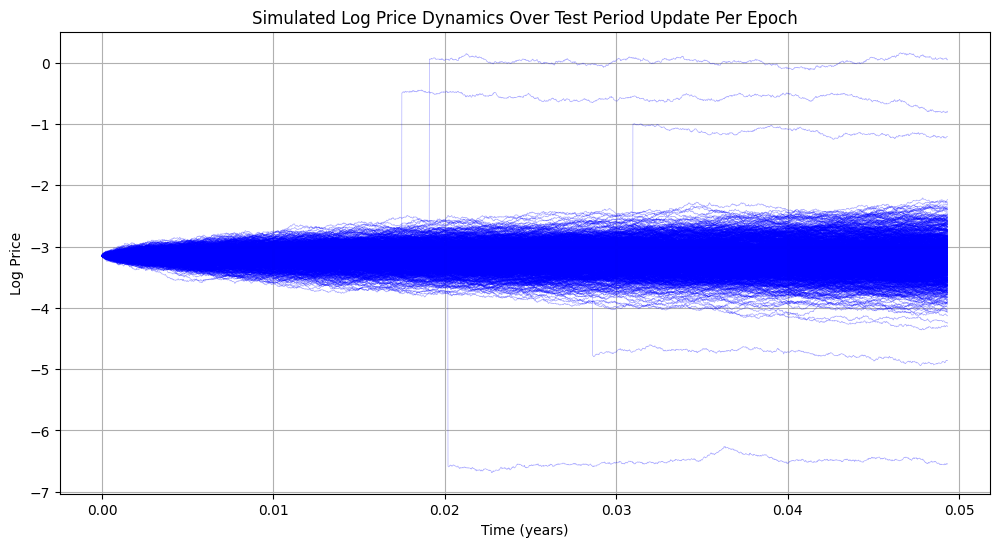

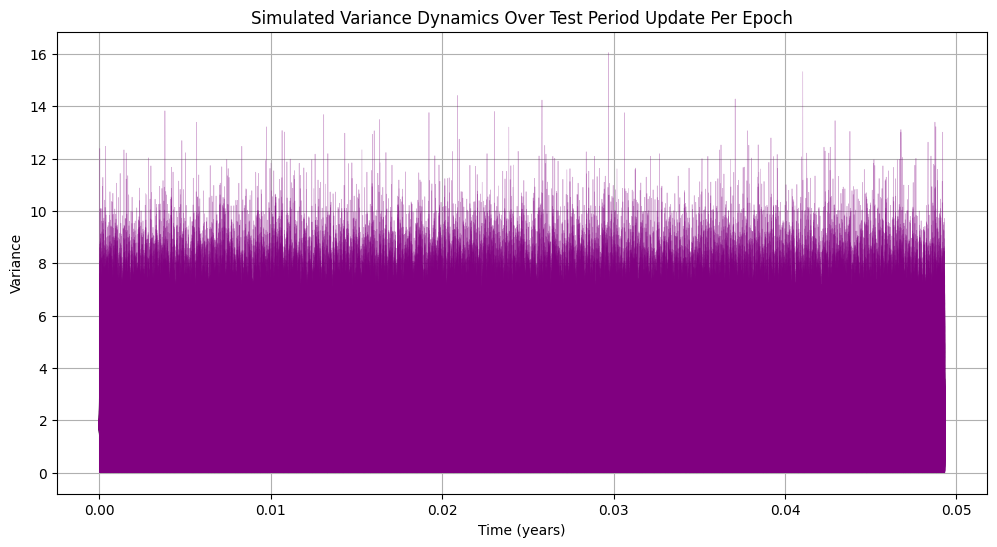

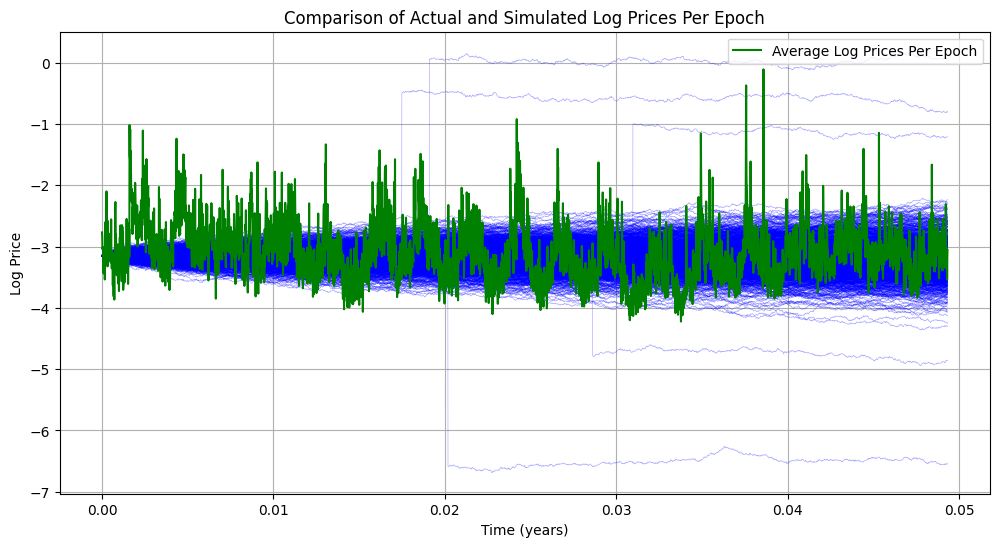

In [7]:
##################################
## MEV Path Analysis 32 Slots ##
##################################
# Plotting the results for all the paths
plt.figure(figsize=(12, 6))
for path in range(S.shape[1]):  # S.shape[1] gives the number of paths
    plt.plot(np.linspace(0, T, N), S[:, path], lw=0.5, alpha=0.3, color='blue')
plt.title('Simulated Log Price Dynamics Over Test Period Update Per Epoch')
plt.xlabel('Time (years)')
plt.ylabel('Log Price')
plt.grid(True)
plt.show()

# Plotting the results for all the paths
plt.figure(figsize=(12, 6))
for path in range(v.shape[1]):  # S.shape[1] gives the number of paths
    plt.plot(np.linspace(0, T, N), v[:, path], lw=0.5, alpha=0.3, color='purple')
plt.title('Simulated Variance Dynamics Over Test Period Update Per Epoch')
plt.xlabel('Time (years)')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

# Average log prices over fixed intervals
epoch_prices = np.array([np.mean(log_prices_test[i:i+32]) for i in range(0, len(log_prices_test), 32)])
total_epochs = len(epoch_prices)

# Mean of all paths
mean_S = np.mean(S, axis=1)
median_S = np.median(S, axis=1)
plt.figure(figsize=(12, 6))

# Time arrays for plotting
simulated_times = np.linspace(0, T, N)
actual_times = np.linspace(0, T, total_epochs)
# Plot simulated data
for path in range(S.shape[1]):  # S.shape[1] gives the number of paths
    plt.plot(np.linspace(0, T, N), S[:, path], lw=0.5, alpha=0.3, color='blue')
plt.plot(actual_times, epoch_prices, label='Average Log Prices Per Epoch', color='green')
# Finalizing the plot
plt.title('Comparison of Actual and Simulated Log Prices Per Epoch')
plt.xlabel('Time (years)')
plt.ylabel('Log Price')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [8]:
# Calculate RMSE & MAE between the actual epoch prices and the simulated mean prices
mean_S = np.mean(S, axis=1)
simulated_epoch_prices = mean_S[:total_epochs]
# Calculate RMSE between the actual epoch prices and the simulated mean prices
rmse = np.sqrt(mean_squared_error(epoch_prices, simulated_epoch_prices))
print(f"RMSE MAE actual and simulated log prices: {rmse}")
# Calculate RMSE between the actual epoch prices and the simulated mean prices
mae = np.mean(np.abs(epoch_prices - simulated_epoch_prices))
print(f"MAE between actual and simulated log prices: {mae}")

RMSE MAE actual and simulated log prices: 0.47225630737026836
MAE between actual and simulated log prices: 0.3597997164939593


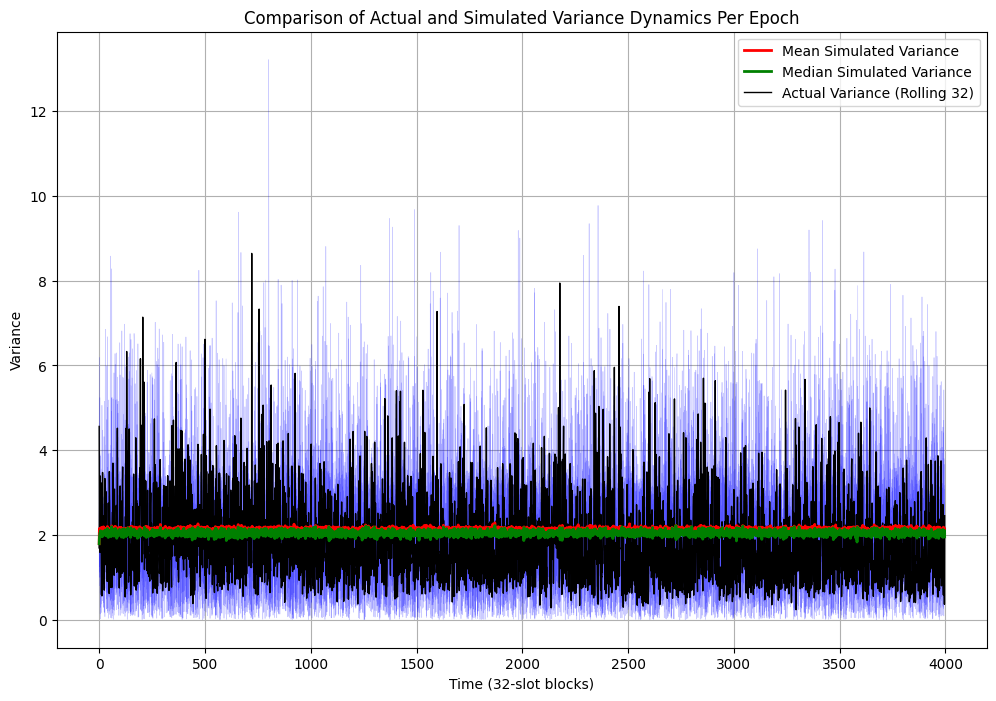

Actual number of jumps: 39
Simulated average number of jumps across paths: 12.812
Simulated median number of jumps across paths: 13.0


In [9]:
###################################################
## Volatility Analysis for 32-Slot Blocks ##
###################################################

# Simulation parameters
T = 18 / 365  # Total simulation time in years (18 days)
num_paths = 1000  # Number of Monte Carlo paths
N = 4048  # Expected number of time steps (18 days, per epoch)

# Define the window size for block variance analysis
window_size = 32

# Calculate block variances using rolling windows of 32 time steps
block_variances_32blocks = [
    log_returns_test[i:i + window_size].var() 
    for i in range(0, len(log_returns_test), window_size) 
    if i + window_size <= len(log_returns_test)
]

# Convert block variances to a pandas Series for further analysis
actual_variance = pd.Series(block_variances_32blocks)
actual_variance_diff = actual_variance.diff().dropna()

# Adjust the simulated variance to match the actual data's length
v_truncated = v[:len(actual_variance), :]
simulated_variance_diff = np.diff(v_truncated, axis=0)

# Set the jump threshold as a multiple of the standard deviation
jump_threshold_multiplier = 3
actual_jump_threshold = jump_threshold_multiplier * np.std(actual_variance_diff)
simulated_jump_threshold = jump_threshold_multiplier * np.std(simulated_variance_diff, axis=0)

# Detect significant jumps in actual and simulated variance differences
actual_jumps = (np.abs(actual_variance_diff) > actual_jump_threshold).astype(int)
actual_jump_count = actual_jumps.sum()
simulated_jumps = (np.abs(simulated_variance_diff) > simulated_jump_threshold).astype(int)
simulated_jump_counts = simulated_jumps.sum(axis=0)

# Plot the dynamics of simulated variance for a selection of paths
plt.figure(figsize=(12, 8))
for path in range(min(5, num_paths)):  # Limit the number of paths plotted for better visibility
    plt.plot(v_truncated[:, path], lw=0.5, alpha=0.2, color='blue')

# Include mean and median lines of the simulated variance
mean_v_truncated = np.mean(v_truncated, axis=1)
median_v_truncated = np.median(v_truncated, axis=1)
plt.plot(mean_v_truncated, 'r', label='Mean Simulated Variance', linewidth=2, zorder=3)
plt.plot(median_v_truncated, 'g', label='Median Simulated Variance', linewidth=2, zorder=3)

# Plot the actual variance computed over 32 slots
plt.plot(actual_variance.values, 'k', label='Actual Variance (Rolling 32)', linewidth=1)
plt.title('Comparison of Actual and Simulated Variance Dynamics Per Epoch')
plt.xlabel('Time (32-slot blocks)')
plt.ylabel('Variance')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Output the jump analysis results
print(f"Actual number of jumps: {actual_jump_count}")
print(f"Simulated average number of jumps across paths: {np.mean(simulated_jump_counts)}")
print(f"Simulated median number of jumps across paths: {np.median(simulated_jump_counts)}")

In [10]:
# Calculate RMSE between actual variance and mean simulated variance
mean_v_truncated = np.mean(v_truncated, axis=1)
rmse_variance = np.sqrt(mean_squared_error(actual_variance, mean_v_truncated))
print(f"RMSE between actual and simulated variance per epoch: {rmse_variance}")
mae = np.mean(np.abs(actual_variance - mean_v_truncated))
print(f"MAE between actual and simulated variance per epoch: {mae}")

RMSE between actual and simulated variance per epoch: 1.0032858014435921
MAE between actual and simulated variance per epoch: 0.8208703490084538


In [11]:
#############################################
## Find Initial Parameters Value 64 Slots ##
#############################################
# Define window size
window_size = 64
# Calculate block variance
block_variances_64blocks = [log_returns_train[i:i+window_size].var() for i in range(0, len(log_returns_train), window_size) if i+window_size <= len(log_returns_train)]
# Convert to Series for further analysis
rolling_variance_64slots = pd.Series(block_variances_64blocks)
# Define dt
dt = 1/(82125*1/2) # in years

# Find Kappa 
def estimate_kappa(rolling_variance, dt):
    log_variance = np.log(rolling_variance)
    autocorr = np.corrcoef(log_variance[:-1], log_variance[1:])[0, 1]
    kappa = -np.log(autocorr) / dt
    return kappa

initial_kappa = estimate_kappa(rolling_variance_64slots, dt)
print("Initial kappa is: ", initial_kappa)

# Find Sigma 
def estimate_sigma(rolling_variance, dt):
    log_variance = np.log(rolling_variance)
    diff_log_variance = np.diff(log_variance)
    sigma = np.sqrt(np.var(diff_log_variance) / dt)
    return sigma

initial_sigma = estimate_sigma(rolling_variance_64slots, dt)
print("Initial sigma is: ", initial_sigma)

# Estimate initial Mu
initial_mu = np.mean(log_returns_train)
print("Initial mu is: ", initial_mu)

# Estimate initial theta
initial_theta = np.var(log_returns_train)
print("Initial theta is: ", initial_theta)

# Estimate initial jump parameters (lambda_j, mu_j, sigma_j)
def estimate_jump_params(log_prices, window_size, dt, threshold_multiplier=1.5):
    # Calculate the log price changes
    diff_log_prices = np.diff(log_prices)
    
    # Define the threshold
    threshold = threshold_multiplier * np.std(diff_log_prices)
    
    # Identify jumps as changes in log prices that exceed the threshold
    jump_indices = np.where(np.abs(diff_log_prices) > threshold)[0]
    
    # Estimate jump intensity lambda_j (Poisson parameter) per unit time dt
    jump_intensity = len(jump_indices) / len(log_prices) 
    
    # Estimate jump size mu_j as the average of significant jumps (those above the threshold)
    significant_jumps = diff_log_prices[jump_indices]
    jump_size = np.mean(significant_jumps)
    
    # Estimate jump volatility sigma_j as the standard deviation of significant jumps
    jump_volatility = np.std(significant_jumps)
    
    return jump_size, jump_intensity, jump_volatility

# Find Jump Size, Lambda, and Sigma_j
initial_mu_j, initial_lambda_j, initial_sigma_j = estimate_jump_params(log_prices_train, window_size, dt)
print("Initial jump size (mu_j) is: ", initial_mu_j)
print("Initial jump intensity (lambda_j) is: ", initial_lambda_j)
print("Initial jump volatility (sigma_j) is: ", initial_sigma_j)

def estimate_variance_jump_params(rolling_variance, dt, threshold_percentile=90):
    # Calculate the changes in variance
    diff_variance = np.diff(rolling_variance)
    
    # Define the threshold for jumps in variance based on the empirical distribution
    threshold = np.percentile(np.abs(diff_variance), threshold_percentile)

    # Identify jumps as changes in variance that exceed the threshold
    jump_indices = np.where(np.abs(diff_variance) > threshold)[0]
    
    # Estimate jump intensity lambda_j_v (Poisson parameter) per unit time dt
    jump_intensity_v = len(jump_indices) / len(rolling_variance)
    
    # Estimate jump size mu_j_v using a log-normal approach to ensure positive values
    significant_jumps_v = diff_variance[jump_indices]
    jump_size_v = np.median(np.log(np.abs(significant_jumps_v) + 1))
    
    # Estimate jump volatility sigma_j_v as the standard deviation of log-jump sizes
    log_jumps = np.log(np.abs(significant_jumps_v) + 1)
    jump_volatility_v = np.std(log_jumps)
    
    return jump_size_v, jump_intensity_v, jump_volatility_v, threshold

# Find Jump Size, Lambda, and Sigma_j for variance
initial_mu_j_v, initial_lambda_j_v, initial_sigma_j_v, threshold = estimate_variance_jump_params(rolling_variance_64slots, dt, threshold_percentile=90)
print("Initial variance jump size (mu_j_v) is: ", initial_mu_j_v)
print("Initial variance jump intensity (lambda_j_v) is: ", initial_lambda_j_v)
print("Initial variance jump volatility (sigma_j_v) is: ", initial_sigma_j_v)

Initial kappa is:  57503.25579264724
Initial sigma is:  106.66797283771687
Initial mu is:  -4.1655358788419694e-07
Initial theta is:  1.7941995110032327
Initial jump size (mu_j) is:  0.36091714626793653
Initial jump intensity (lambda_j) is:  0.11808426018757927
Initial jump volatility (sigma_j) is:  3.1172813186272053
Initial variance jump size (mu_j_v) is:  1.066766109598206
Initial variance jump intensity (lambda_j_v) is:  0.10007505629221916
Initial variance jump volatility (sigma_j_v) is:  0.14752221492326426


In [12]:
#########################################
## Log Likelihood Estimation 64 Slots ##
#########################################
def bates_log_likelihood(params, log_prices):
    mu, kappa, theta, sigma, rho, lambda_j, mu_j, sigma_j, lambda_j_v, mu_j_v, sigma_j_v  = params
    n = len(log_prices)
    dt = 1/(82125*1/2)

    # Initialize the variance and log-likelihood
    v = np.var(np.diff(log_prices))  # Initial variance estimate
    log_likelihood = 0
    
    # Generate correlated Brownian motions
    dW = np.random.multivariate_normal([0, 0], [[1, rho], [rho, 1]], n - 1) * np.sqrt(dt)
    dW1, dW2 = dW[:, 0], dW[:, 1]
    
    for i in range(1, n):
        # Simplified jump component: Additive jumps directly to the log price
        dN_v = np.random.poisson(lambda_j_v)  # Number of jumps in the interval
        if dN_v > 0:
            J_v = np.sum(np.random.normal(mu_j_v, sigma_j_v, dN_v))  # Simplified additive jumps
        else:
            J_v = 0
        
        v_next = max(0, v) + kappa * (theta - max(0, v)) * dt + sigma * np.sqrt(max(0, v)) * dW2[i - 1] + J_v
        
        # Simplified jump component: Additive jumps directly to the log price
        dN = np.random.poisson(lambda_j * dt)  # Number of jumps in the interval
        if dN > 0:
            J = np.sum(np.random.normal(mu_j, sigma_j, dN))  # Simplified additive jumps
        else:
            J = 0
        
        dY = (mu - 0.5 * max(0, v)) * dt + np.sqrt(max(0, v)) * dW1[i - 1] + J
        
        # Update log-likelihood
        log_likelihood += -0.5 * (np.log(2 * np.pi * max(0.0001, v)) + (log_prices[i] - log_prices[i - 1] - dY) ** 2 / max(0.0001, v))
        v = v_next

    return -log_likelihood

def optimize_parameters(log_prices):
    # Define bounds and initial guesses
    bounds = [(None, None), (0, None), (0, None), (0, None), (-1, 1), (0, None), (None, None), (0, None), (0, None), (None, None), (0, None)]
    initial_guess = [initial_mu, initial_kappa, initial_theta, initial_sigma, 0, initial_lambda_j, initial_mu_j, initial_sigma_j, initial_lambda_j_v, initial_mu_j_v, initial_sigma_j_v]

    # Minimize the negative log likelihood
    result = opt.minimize(bates_log_likelihood, initial_guess, args=(log_prices), bounds=bounds)

    return result.x

optimized_params = optimize_parameters(log_prices_train)
print("Adjusted parameters:", optimized_params)

estimated_mu, estimated_kappa, estimated_theta, estimated_sigma, estimated_rho, estimated_lambda_j, estimated_mu_j, estimated_sigma_j, estimated_lambda_j_v, estimated_mu_j_v, estimated_sigma_j_v = optimized_params

Adjusted parameters: [-8.55251673e-07  5.75032558e+04  1.79419951e+00  1.06667973e+02
 -1.31915731e-08  1.18084258e-01  3.60917086e-01  3.11728132e+00
  1.00075068e-01  1.06676584e+00  1.47522216e-01]


In [13]:
#####################################
## Monte Carlo Simulation 64 Slots ##
#####################################
T = 18 / 365  # Total time in years for simulation (18 days)
dt = 1 / (82125*1/2)  # Delta t in years per epoch
num_paths = 1000  # Number of Monte Carlo paths
N = 2024  # Total number of time steps (Per Epoch)

# Initial conditions
S0 = np.median(log_prices_train)  # Start from the median log price in the train dataset
v0 = np.var(log_returns_train)  # Initial variance, estimated from the train log returns

# Arrays to store simulations
S = np.zeros((N, num_paths))
v = np.zeros((N, num_paths))

S[0, :] = S0
v[0, :] = v0

# Generate correlated random shocks for each path
for path in range(num_paths):
    dW = np.random.multivariate_normal([0, 0], [[1, estimated_rho], [estimated_rho, 1]], N) * np.sqrt(dt)
    dW1, dW2 = dW[:, 0], dW[:, 1]

    for i in range(1, N):

        dN_v= np.random.poisson(estimated_lambda_j_v)  # Number of jumps in the interval
        if dN_v > 0:
            J_v = np.sum(np.exp(np.random.normal(estimated_mu_j_v, estimated_sigma_j_v, dN_v))-1)  # Simplified additive jumps
        else:
            J_v = 0

        v_prev = v[i - 1, path]
        v_drift = estimated_kappa * (estimated_theta - max(v_prev, 0)) * dt
        v_diffusion = estimated_sigma * np.sqrt(max(v_prev, 0)) * dW2[i - 1]
        
        # Calculate the variance before adding jumps to ensure it's non-negative
        v_next = np.abs(v_prev + v_drift + v_diffusion)

        # Add the jump component, ensuring variance remains non-negative
        v[i, path] = np.abs(v_next + J_v)
        

        dN = np.random.poisson(estimated_lambda_j * dt)  # Number of jumps in the interval
        if dN > 0:
            J = np.sum(np.random.normal(estimated_mu_j, estimated_sigma_j, dN))  # Simplified additive jumps
        else:
            J = 0
        
        # Update log price with drift, diffusion, and jump components
        S[i, path] = S[i - 1, path] + (estimated_mu - 0.5 * max(v[i, path], 0)) * dt + np.sqrt(max(v[i, path], 0)) * dW1[i - 1] + J

print("Shape of v:", v.shape)

Shape of v: (2024, 1000)


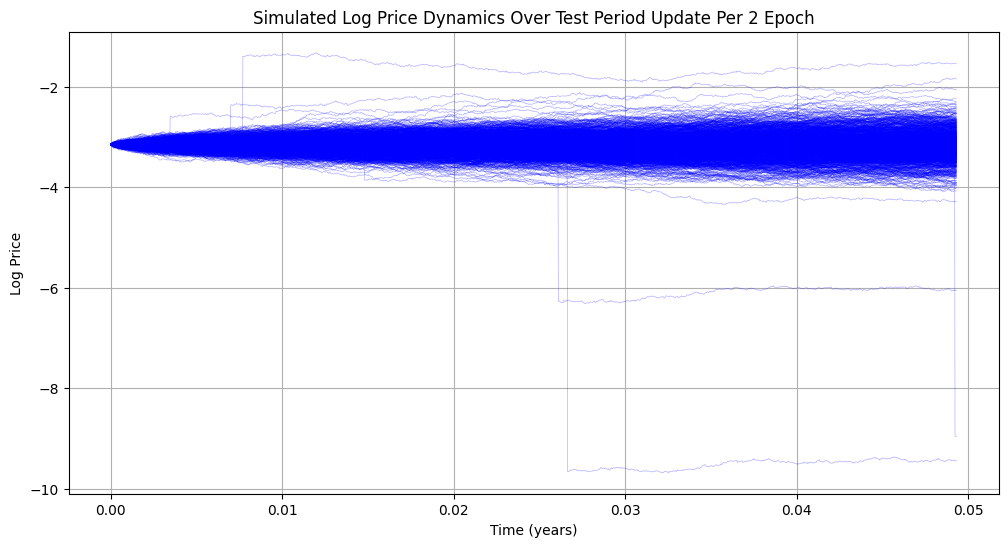

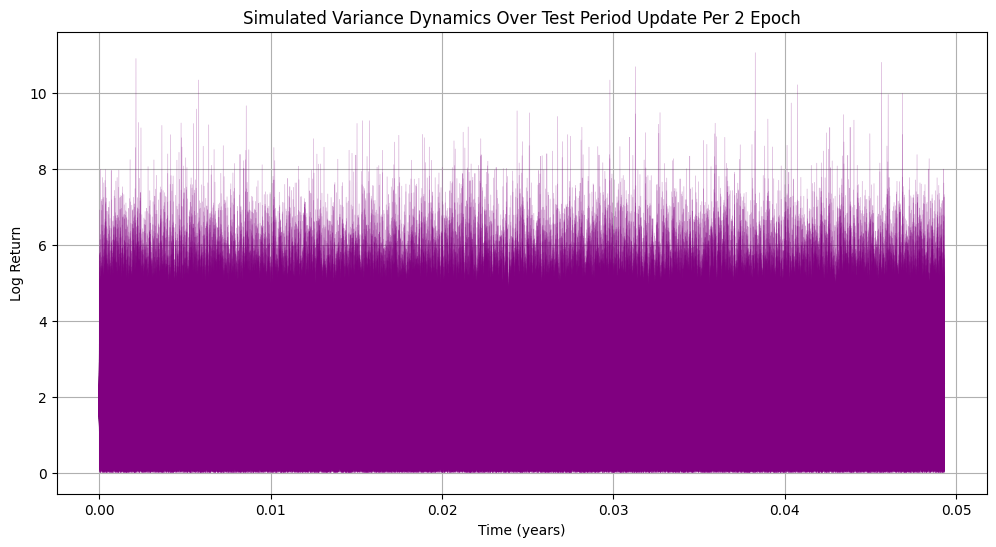

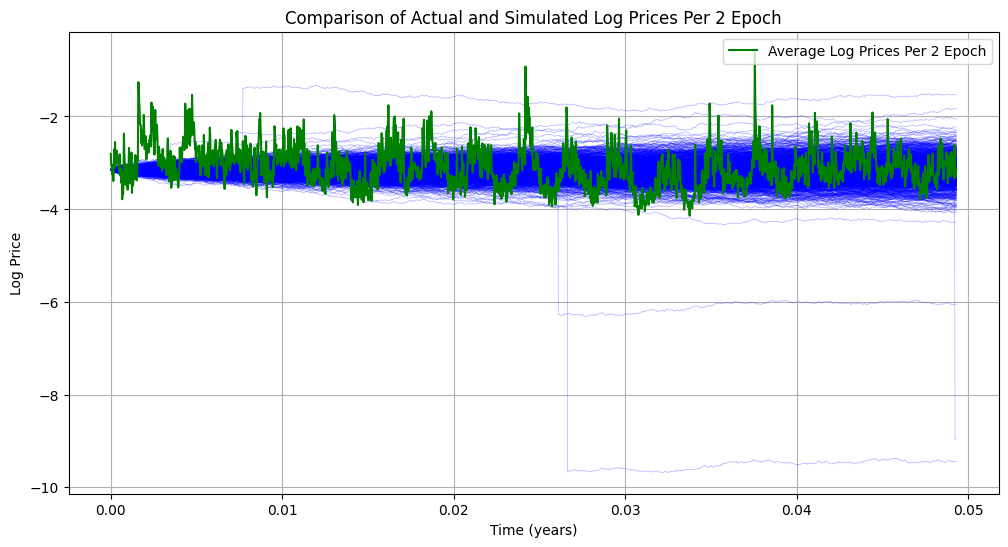

In [14]:
##################################
## MEV Path Analysis 64 Slots ##
##################################
# Plotting the results for all the paths
plt.figure(figsize=(12, 6))
for path in range(S.shape[1]):  # S.shape[1] gives the number of paths
    plt.plot(np.linspace(0, T, N), S[:, path], lw=0.5, alpha=0.3, color='blue')
plt.title('Simulated Log Price Dynamics Over Test Period Update Per 2 Epoch')
plt.xlabel('Time (years)')
plt.ylabel('Log Price')
plt.grid(True)
plt.show()

# Plotting the results for all the paths
plt.figure(figsize=(12, 6))
for path in range(v.shape[1]):  # S.shape[1] gives the number of paths
    plt.plot(np.linspace(0, T, N), v[:, path], lw=0.5, alpha=0.3, color='purple')
plt.title('Simulated Variance Dynamics Over Test Period Update Per 2 Epoch')
plt.xlabel('Time (years)')
plt.ylabel('Log Return')
plt.grid(True)
plt.show()

# Average log prices over fixed intervals
epoch_prices = np.array([np.mean(log_prices_test[i:i+64]) for i in range(0, len(log_prices_test), 64)])
total_epochs = len(epoch_prices)

# Mean of all paths
mean_S = np.mean(S, axis=1)
median_S = np.median(S, axis=1)
plt.figure(figsize=(12, 6))

# Time arrays for plotting
simulated_times = np.linspace(0, T, N)
actual_times = np.linspace(0, T, total_epochs)

# Plot simulated data
for path in range(S.shape[1]):  # S.shape[1] gives the number of paths
    plt.plot(np.linspace(0, T, N), S[:, path], lw=0.5, alpha=0.3, color='blue')
plt.plot(actual_times, epoch_prices, label='Average Log Prices Per 2 Epoch', color='green')
# Finalizing the plot
plt.title('Comparison of Actual and Simulated Log Prices Per 2 Epoch')
plt.xlabel('Time (years)')
plt.ylabel('Log Price')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [15]:
# Calculate RMSE & MAE between the actual epoch prices and the simulated mean prices
mean_S = np.mean(S, axis=1)
simulated_epoch_prices = mean_S[:total_epochs]
# Calculate RMSE between the actual epoch prices and the simulated mean prices
rmse = np.sqrt(mean_squared_error(epoch_prices, simulated_epoch_prices))
print(f"RMSE between actual and simulated log prices: {rmse}")
# Calculate MAE between the actual epoch prices and the simulated mean prices
mae = np.mean(np.abs(epoch_prices - simulated_epoch_prices))
print(f"MAE between actual and simulated log prices: {mae}")

RMSE between actual and simulated log prices: 0.4361478459906176
MAE between actual and simulated log prices: 0.334640864418046


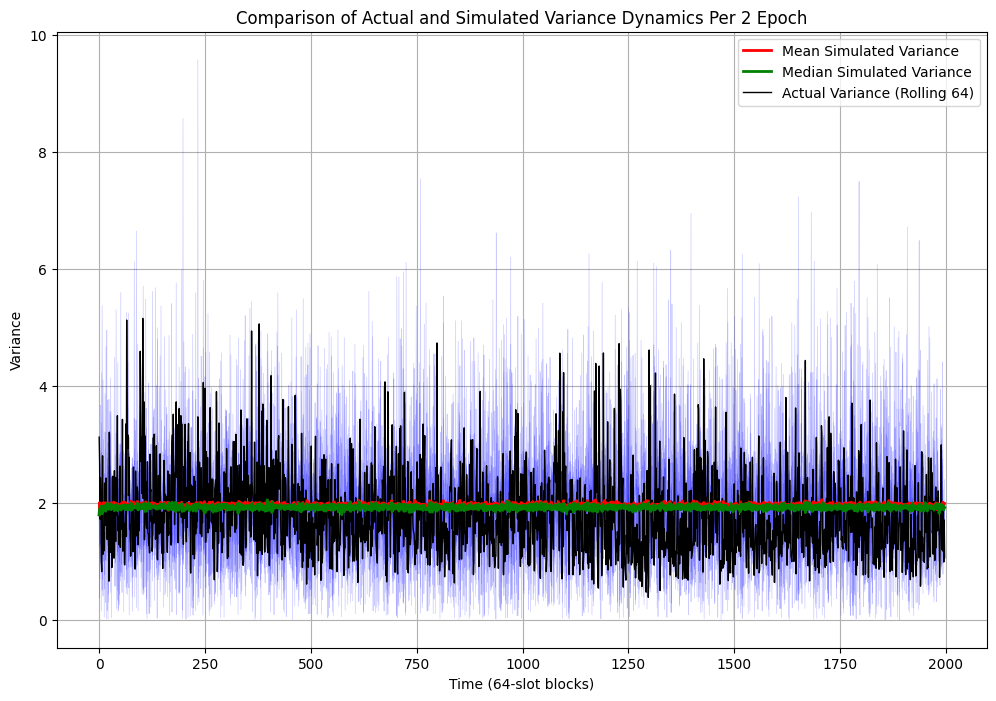

Actual number of jumps: 18
Simulated average number of jumps across paths: 11.094
Simulated median number of jumps across paths: 11.0


In [16]:
###################################################
## Variance Dynamics Analysis for 64-Slot Blocks ##
###################################################

# Simulation parameters
T = 18 / 365  # Total simulation time in years (18 days)
num_paths = 1000  # Number of Monte Carlo paths
N = 2024  # Expected number of time steps (18 days, per 2 epochs)

# Define the window size for block variance analysis
window_size = 64

# Calculate block variances using rolling windows of 64 time steps
block_variances_64blocks = [
    log_returns_test[i:i + window_size].var() 
    for i in range(0, len(log_returns_test), window_size) 
    if i + window_size <= len(log_returns_test)
]

# Convert block variances to a pandas Series for detailed analysis
actual_variance = pd.Series(block_variances_64blocks)
actual_variance_diff = actual_variance.diff().dropna()

# Adjust the simulated variance to match the actual data's length
v_truncated = v[:len(actual_variance), :]
simulated_variance_diff = np.diff(v_truncated, axis=0)

# Set the jump threshold as a multiple of the standard deviation
jump_threshold_multiplier = 3
actual_jump_threshold = jump_threshold_multiplier * np.std(actual_variance_diff)
simulated_jump_threshold = jump_threshold_multiplier * np.std(simulated_variance_diff, axis=0)

# Detect significant jumps in actual and simulated variance differences
actual_jumps = (np.abs(actual_variance_diff) > actual_jump_threshold).astype(int)
actual_jump_count = actual_jumps.sum()
simulated_jumps = (np.abs(simulated_variance_diff) > simulated_jump_threshold).astype(int)
simulated_jump_counts = simulated_jumps.sum(axis=0)

# Plot the dynamics of simulated variance for a selection of paths
plt.figure(figsize=(12, 8))
for path in range(min(5, num_paths)):  # Limit the number of paths plotted for better visibility
    plt.plot(v_truncated[:, path], lw=0.5, alpha=0.2, color='blue')

# Include mean and median lines of the simulated variance
mean_v_truncated = np.mean(v_truncated, axis=1)
median_v_truncated = np.median(v_truncated, axis=1)
plt.plot(mean_v_truncated, 'r', label='Mean Simulated Variance', linewidth=2, zorder=3)
plt.plot(median_v_truncated, 'g', label='Median Simulated Variance', linewidth=2, zorder=3)

# Plot the actual variance computed over 64 slots
plt.plot(actual_variance.values, 'k', label='Actual Variance (Rolling 64)', linewidth=1)
plt.title('Comparison of Actual and Simulated Variance Dynamics Per 2 Epoch')
plt.xlabel('Time (64-slot blocks)')
plt.ylabel('Variance')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Output the jump analysis results
print(f"Actual number of jumps: {actual_jump_count}")
print(f"Simulated average number of jumps across paths: {np.mean(simulated_jump_counts)}")
print(f"Simulated median number of jumps across paths: {np.median(simulated_jump_counts)}")

In [17]:
# Calculate RMSE between actual variance and mean simulated variance
mean_v_truncated = np.mean(v_truncated, axis=1)
rmse_variance = np.sqrt(mean_squared_error(actual_variance, mean_v_truncated))
print(f"RMSE between actual and simulated variance: {rmse_variance}")
mae = np.mean(np.abs(actual_variance - mean_v_truncated))
print(f"MAE between actual and simulated variance: {mae}")

RMSE between actual and simulated variance: 0.7285923713488293
MAE between actual and simulated variance: 0.5850151538086746


In [18]:
#############################################
## Find Initial Parameters Value 150 Slots ##
#############################################
# Define window size
window_size = 150
# Calculate block variance
block_variances_150blocks = [log_returns_train[i:i+window_size].var() for i in range(0, len(log_returns_train), window_size) if i+window_size <= len(log_returns_train)]
# Convert to Series for further analysis
rolling_variance_150slots = pd.Series(block_variances_150blocks)
# Define dt
dt = 1/(365 * 24 * 2) # in years

# Find Kappa 
def estimate_kappa(rolling_variance, dt):
    log_variance = np.log(rolling_variance)
    autocorr = np.corrcoef(log_variance[:-1], log_variance[1:])[0, 1]
    kappa = -np.log(autocorr) / dt
    return kappa

initial_kappa = estimate_kappa(rolling_variance_150slots, dt)
print("Initial kappa is: ", initial_kappa)

# Find Sigma 
def estimate_sigma(rolling_variance, dt):
    log_variance = np.log(rolling_variance)
    diff_log_variance = np.diff(log_variance)
    sigma = np.sqrt(np.var(diff_log_variance) / dt)
    return sigma

initial_sigma = estimate_sigma(rolling_variance_150slots, dt)
print("Initial sigma is: ", initial_sigma)

# Estimate initial Mu
initial_mu = np.mean(log_returns_train)
print("Initial mu is: ", initial_mu)

# Estimate initial theta
initial_theta = np.var(log_returns_train)
print("Initial theta is: ", initial_theta)

# Estimate initial jump parameters (lambda_j, mu_j, sigma_j)
def estimate_jump_params(log_prices, window_size, dt, threshold_multiplier=1.5):
    # Calculate the log price changes
    diff_log_prices = np.diff(log_prices)
    
    # Define the threshold
    threshold = threshold_multiplier * np.std(diff_log_prices)
    
    # Identify jumps as changes in log prices that exceed the threshold
    jump_indices = np.where(np.abs(diff_log_prices) > threshold)[0]
    
    # Estimate jump intensity lambda_j (Poisson parameter) per unit time dt
    jump_intensity = len(jump_indices) / len(log_prices) 
    
    # Estimate jump size mu_j as the average of significant jumps (those above the threshold)
    significant_jumps = diff_log_prices[jump_indices]
    jump_size = np.mean(significant_jumps)
    
    # Estimate jump volatility sigma_j as the standard deviation of significant jumps
    jump_volatility = np.std(significant_jumps)
    
    return jump_size, jump_intensity, jump_volatility

# Find Jump Size, Lambda, and Sigma_j
initial_mu_j, initial_lambda_j, initial_sigma_j = estimate_jump_params(log_prices_train, window_size, dt)
print("Initial jump size (mu_j) is: ", initial_mu_j)
print("Initial jump intensity (lambda_j) is: ", initial_lambda_j)
print("Initial jump volatility (sigma_j) is: ", initial_sigma_j)

def estimate_variance_jump_params(rolling_variance, dt, threshold_percentile=90):
    # Calculate the changes in variance
    diff_variance = np.diff(rolling_variance)
    
    # Define the threshold for jumps in variance based on the empirical distribution
    threshold = np.percentile(np.abs(diff_variance), threshold_percentile)

    # Identify jumps as changes in variance that exceed the threshold
    jump_indices = np.where(np.abs(diff_variance) > threshold)[0]
    
    # Estimate jump intensity lambda_j_v (Poisson parameter) per unit time dt
    jump_intensity_v = len(jump_indices) / len(rolling_variance)
    
    # Estimate jump size mu_j_v using a log-normal approach to ensure positive values
    significant_jumps_v = diff_variance[jump_indices]
    jump_size_v = np.median(np.log(np.abs(significant_jumps_v) + 1))
    
    # Estimate jump volatility sigma_j_v as the standard deviation of log-jump sizes
    log_jumps = np.log(np.abs(significant_jumps_v) + 1)
    jump_volatility_v = np.std(log_jumps)
    
    return jump_size_v, jump_intensity_v, jump_volatility_v, threshold

# Find Jump Size, Lambda, and Sigma_j for variance
initial_mu_j_v, initial_lambda_j_v, initial_sigma_j_v, threshold = estimate_variance_jump_params(rolling_variance_150slots, dt, threshold_percentile=90)
print("Initial variance jump size (mu_j_v) is: ", initial_mu_j_v)
print("Initial variance jump intensity (lambda_j_v) is: ", initial_lambda_j_v)
print("Initial variance jump volatility (sigma_j_v) is: ", initial_sigma_j_v)

Initial kappa is:  17560.72947051288
Initial sigma is:  47.85857553652082
Initial mu is:  -4.1655358788419694e-07
Initial theta is:  1.7941995110032327
Initial jump size (mu_j) is:  0.36091714626793653
Initial jump intensity (lambda_j) is:  0.11808426018757927
Initial jump volatility (sigma_j) is:  3.1172813186272053
Initial variance jump size (mu_j_v) is:  0.8472083490028494
Initial variance jump intensity (lambda_j_v) is:  0.09997068308413955
Initial variance jump volatility (sigma_j_v) is:  0.13627033997218896


In [19]:
#########################################
## Log Likelihood Estimation 150 Slots ##
#########################################
def bates_log_likelihood(params, log_prices):
    mu, kappa, theta, sigma, rho, lambda_j, mu_j, sigma_j, lambda_j_v, mu_j_v, sigma_j_v  = params
    n = len(log_prices)
    dt = 1/(365 * 24 * 2) # in years

    # Initialize the variance and log-likelihood
    v = np.var(np.diff(log_prices))  # Initial variance estimate
    log_likelihood = 0
    
    # Generate correlated Brownian motions
    dW = np.random.multivariate_normal([0, 0], [[1, rho], [rho, 1]], n - 1) * np.sqrt(dt)
    dW1, dW2 = dW[:, 0], dW[:, 1]
    
    for i in range(1, n):
        # Simplified jump component: Additive jumps directly to the log price
        dN_v = np.random.poisson(lambda_j_v)  # Number of jumps in the interval
        if dN_v > 0:
            J_v = np.sum(np.random.normal(mu_j_v, sigma_j_v, dN_v))  # Simplified additive jumps
        else:
            J_v = 0
        
        v_next = max(0, v) + kappa * (theta - max(0, v)) * dt + sigma * np.sqrt(max(0, v)) * dW2[i - 1] + J_v
        
        # Simplified jump component: Additive jumps directly to the log price
        dN = np.random.poisson(lambda_j * dt)  # Number of jumps in the interval
        if dN > 0:
            J = np.sum(np.random.normal(mu_j, sigma_j, dN))  # Simplified additive jumps
        else:
            J = 0
        
        dY = (mu - 0.5 * max(0, v)) * dt + np.sqrt(max(0, v)) * dW1[i - 1] + J
        
        # Update log-likelihood
        log_likelihood += -0.5 * (np.log(2 * np.pi * max(0.0001, v)) + (log_prices[i] - log_prices[i - 1] - dY) ** 2 / max(0.0001, v))
        v = v_next

    return -log_likelihood

def optimize_parameters(log_prices):
    # Define bounds and initial guesses
    bounds = [(None, None), (0, None), (0, None), (0, None), (-1, 1), (0, None), (None, None), (0, None), (0, None), (None, None), (0, None)]
    initial_guess = [initial_mu, initial_kappa, initial_theta, initial_sigma, 0, initial_lambda_j, initial_mu_j, initial_sigma_j, initial_lambda_j_v, initial_mu_j_v, initial_sigma_j_v]

    # Minimize the negative log likelihood
    result = opt.minimize(bates_log_likelihood, initial_guess, args=(log_prices), bounds=bounds)

    return result.x

optimized_params = optimize_parameters(log_prices_train)
print("Adjusted parameters:", optimized_params)

estimated_mu, estimated_kappa, estimated_theta, estimated_sigma, estimated_rho, estimated_lambda_j, estimated_mu_j, estimated_sigma_j, estimated_lambda_j_v, estimated_mu_j_v, estimated_sigma_j_v = optimized_params

Adjusted parameters: [-4.38640593e-07  1.75607295e+04  1.79419951e+00  4.78585757e+01
 -5.38580790e-21  1.18084410e-01  3.60917114e-01  3.11728138e+00
  9.99706831e-02  8.47208381e-01  1.36270340e-01]


In [20]:
#####################################
## Monte Carlo Simulation 150 Slots #
#####################################
T = 18 / 365  # Total time in years for simulation (18 days)
dt = 1/(365 * 24 * 2) # in years
num_paths = 1000  # Number of Monte Carlo paths
N = 18 * 24 * 2  # Total number of time steps (Per Half Hour)

# Initial conditions
S0 = np.median(log_prices_train)  # Start from the median log price in the train dataset
v0 = np.var(log_returns_train)  # Initial variance, estimated from the train log returns

# Arrays to store simulations
S = np.zeros((N, num_paths))
v = np.zeros((N, num_paths))

S[0, :] = S0
v[0, :] = v0

# Generate correlated random shocks for each path
for path in range(num_paths):
    dW = np.random.multivariate_normal([0, 0], [[1, estimated_rho], [estimated_rho, 1]], N) * np.sqrt(dt)
    dW1, dW2 = dW[:, 0], dW[:, 1]

    for i in range(1, N):

        dN_v= np.random.poisson(estimated_lambda_j_v)  # Number of jumps in the interval
        if dN_v > 0:
            J_v = np.sum(np.exp(np.random.normal(estimated_mu_j_v, estimated_sigma_j_v, dN_v))-1)  # Simplified additive jumps
        else:
            J_v = 0

        v_prev = v[i - 1, path]
        v_drift = estimated_kappa * (estimated_theta - max(v_prev, 0)) * dt
        v_diffusion = estimated_sigma * np.sqrt(max(v_prev, 0)) * dW2[i - 1]
        
        # Calculate the variance before adding jumps to ensure it's non-negative
        v_next = np.abs(v_prev + v_drift + v_diffusion)

        # Add the jump component, ensuring variance remains non-negative
        v[i, path] = np.abs(v_next + J_v)
        

        dN = np.random.poisson(estimated_lambda_j * dt)  # Number of jumps in the interval
        if dN > 0:
            J = np.sum(np.random.normal(estimated_mu_j, estimated_sigma_j, dN))  # Simplified additive jumps
        else:
            J = 0
        
        # Update log price with drift, diffusion, and jump components
        S[i, path] = S[i - 1, path] + (estimated_mu - 0.5 * max(v[i, path], 0)) * dt + np.sqrt(max(v[i, path], 0)) * dW1[i - 1] + J

print("Shape of v:", v.shape)

Shape of v: (864, 1000)


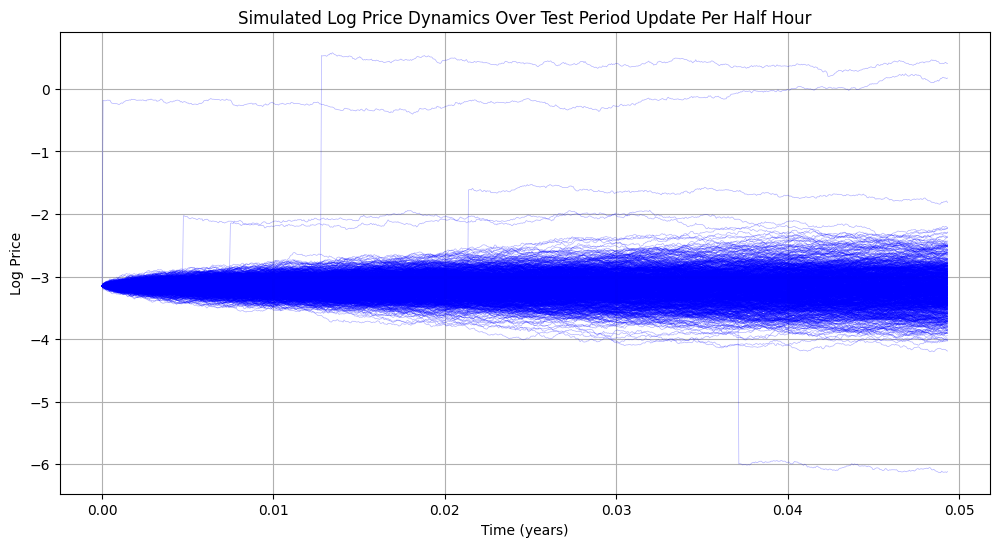

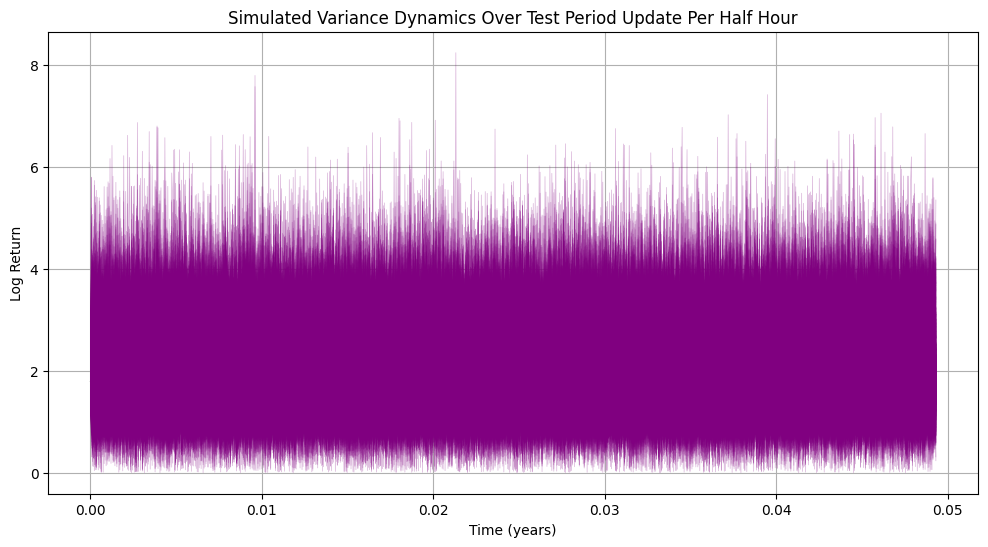

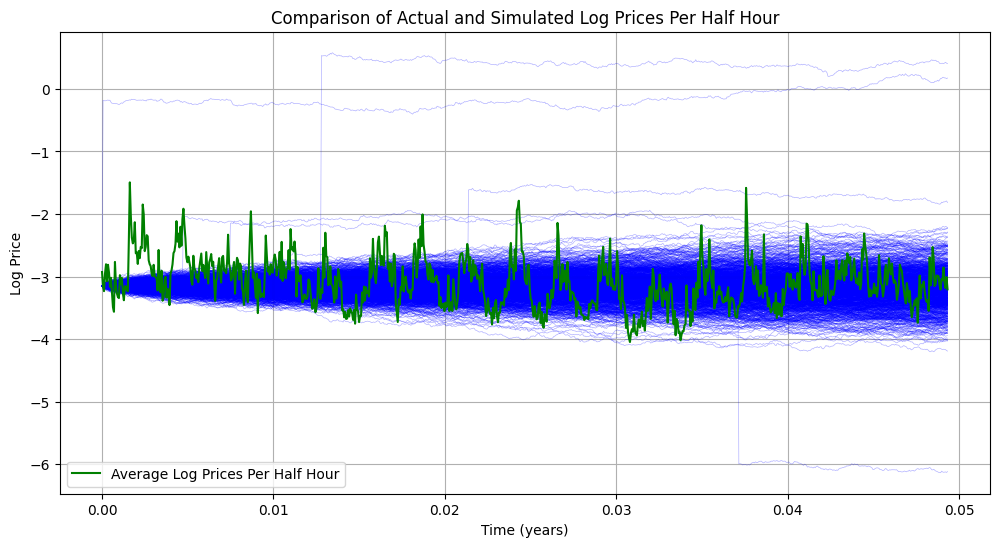

In [21]:
##################################
## MEV Path Analysis 150 Slots ##
##################################
# Plotting the results for all the paths
plt.figure(figsize=(12, 6))
for path in range(S.shape[1]):  # S.shape[1] gives the number of paths
    plt.plot(np.linspace(0, T, N), S[:, path], lw=0.5, alpha=0.3, color='blue')
plt.title('Simulated Log Price Dynamics Over Test Period Update Per Half Hour')
plt.xlabel('Time (years)')
plt.ylabel('Log Price')
plt.grid(True)
plt.show()

# Plotting the results for all the paths
plt.figure(figsize=(12, 6))
for path in range(v.shape[1]):  # S.shape[1] gives the number of paths
    plt.plot(np.linspace(0, T, N), v[:, path], lw=0.5, alpha=0.3, color='purple')
plt.title('Simulated Variance Dynamics Over Test Period Update Per Half Hour')
plt.xlabel('Time (years)')
plt.ylabel('Log Return')
plt.grid(True)
plt.show()

# Average log prices over fixed intervals
epoch_prices = np.array([np.mean(log_prices_test[i:i+150]) for i in range(0, len(log_prices_test), 150)])
total_epochs = len(epoch_prices)

# Mean of all paths
mean_S = np.mean(S, axis=1)
median_S = np.median(S, axis=1)
plt.figure(figsize=(12, 6))

# Time arrays for plotting
simulated_times = np.linspace(0, T, N)
actual_times = np.linspace(0, T, total_epochs)

# Plot simulated data
for path in range(S.shape[1]):  # S.shape[1] gives the number of paths
    plt.plot(np.linspace(0, T, N), S[:, path], lw=0.5, alpha=0.3, color='blue')
plt.plot(actual_times, epoch_prices, label='Average Log Prices Per Half Hour', color='green')
# Finalizing the plot
plt.title('Comparison of Actual and Simulated Log Prices Per Half Hour')
plt.xlabel('Time (years)')
plt.ylabel('Log Price')
plt.grid(True)
plt.legend()
plt.show()

In [22]:
# Calculate RMSE & MAE between the actual epoch prices and the simulated mean prices
mean_S = np.mean(S, axis=1)
simulated_epoch_prices = mean_S[:total_epochs]
# Calculate RMSE between the actual epoch prices and the simulated mean prices
rmse = np.sqrt(mean_squared_error(epoch_prices, simulated_epoch_prices))
print(f"RMSE between actual and simulated log prices: {rmse}")
# Calculate MAE between the actual epoch prices and the simulated mean prices
mae = np.mean(np.abs(epoch_prices - simulated_epoch_prices))
print(f"MAE between actual and simulated log prices: {mae}")

RMSE between actual and simulated log prices: 0.4005043963532289
MAE between actual and simulated log prices: 0.31321259235169807


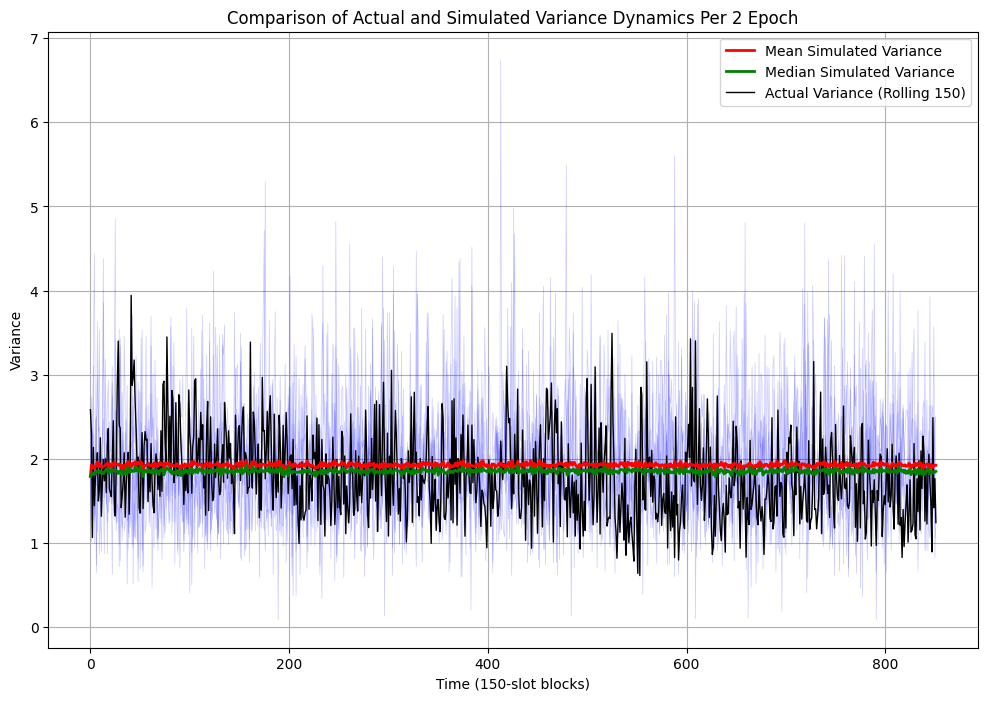

Actual number of jumps: 14
Simulated average number of jumps across paths: 20.972
Simulated median number of jumps across paths: 21.0


In [23]:
###################################################
## Variance Dynamics Analysis for 150-Slot Blocks ##
###################################################

# Simulation parameters
T = 18 / 365  # Total simulation time in years (18 days)
num_paths = 1000  # Number of Monte Carlo paths
N = 2024  # Expected number of time steps (18 days, per 2 epochs)

# Define the window size for block variance analysis
window_size = 150

# Calculate block variances using rolling windows of 150 time steps
block_variances_150blocks = [
    log_returns_test[i:i + window_size].var() 
    for i in range(0, len(log_returns_test), window_size) 
    if i + window_size <= len(log_returns_test)
]

# Convert block variances to a pandas Series for detailed analysis
actual_variance = pd.Series(block_variances_150blocks)
actual_variance_diff = actual_variance.diff().dropna()

# Adjust the simulated variance to match the actual data's length
v_truncated = v[:len(actual_variance), :]
simulated_variance_diff = np.diff(v_truncated, axis=0)

# Set the jump threshold as a multiple of the standard deviation
jump_threshold_multiplier = 2.5
actual_jump_threshold = jump_threshold_multiplier * np.std(actual_variance_diff)
simulated_jump_threshold = jump_threshold_multiplier * np.std(simulated_variance_diff, axis=0)

# Detect significant jumps in actual and simulated variance differences
actual_jumps = (np.abs(actual_variance_diff) > actual_jump_threshold).astype(int)
actual_jump_count = actual_jumps.sum()
simulated_jumps = (np.abs(simulated_variance_diff) > simulated_jump_threshold).astype(int)
simulated_jump_counts = simulated_jumps.sum(axis=0)

# Plot the dynamics of simulated variance for a selection of paths
plt.figure(figsize=(12, 8))
for path in range(min(5, num_paths)):  # Limit the number of paths plotted for better visibility
    plt.plot(v_truncated[:, path], lw=0.5, alpha=0.2, color='blue')

# Include mean and median lines of the simulated variance
mean_v_truncated = np.mean(v_truncated, axis=1)
median_v_truncated = np.median(v_truncated, axis=1)
plt.plot(mean_v_truncated, 'r', label='Mean Simulated Variance', linewidth=2, zorder=3)
plt.plot(median_v_truncated, 'g', label='Median Simulated Variance', linewidth=2, zorder=3)

# Plot the actual variance computed over 150 slots
plt.plot(actual_variance.values, 'k', label='Actual Variance (Rolling 150)', linewidth=1)
plt.title('Comparison of Actual and Simulated Variance Dynamics Per 2 Epoch')
plt.xlabel('Time (150-slot blocks)')
plt.ylabel('Variance')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Output the jump analysis results
print(f"Actual number of jumps: {actual_jump_count}")
print(f"Simulated average number of jumps across paths: {np.mean(simulated_jump_counts)}")
print(f"Simulated median number of jumps across paths: {np.median(simulated_jump_counts)}")


In [24]:
# Calculate RMSE between actual variance and mean simulated variance
mean_v_truncated = np.mean(v_truncated, axis=1)
rmse_variance = np.sqrt(mean_squared_error(actual_variance, mean_v_truncated))
print(f"RMSE between actual and simulated variance Per Half Hour: {rmse_variance}")
mae = np.mean(np.abs(actual_variance - mean_v_truncated))
print(f"MAE between actual and simulated variance Per Half Hour: {mae}")

RMSE between actual and simulated variance Per Half Hour: 0.5201511906229878
MAE between actual and simulated variance Per Half Hour: 0.4246828817771676


In [25]:
#############################################
## Find Initial Parameters Value 300 Slots ##
#############################################
# Define window size
window_size = 300
# Calculate block variance
block_variances_300blocks = [log_returns_train[i:i+window_size].var() for i in range(0, len(log_returns_train), window_size) if i+window_size <= len(log_returns_train)]
# Convert to Series for further analysis
rolling_variance_300slots = pd.Series(block_variances_300blocks)
# Define dt
dt = 1/(365 * 24) # in years

# Find Kappa 
def estimate_kappa(rolling_variance, dt):
    log_variance = np.log(rolling_variance)
    autocorr = np.corrcoef(log_variance[:-1], log_variance[1:])[0, 1]
    kappa = -np.log(autocorr) / dt
    return kappa

initial_kappa = estimate_kappa(rolling_variance_300slots, dt)
print("Initial kappa is: ", initial_kappa)

# Find Sigma 
def estimate_sigma(rolling_variance, dt):
    log_variance = np.log(rolling_variance)
    diff_log_variance = np.diff(log_variance)
    sigma = np.sqrt(np.var(diff_log_variance) / dt)
    return sigma

initial_sigma = estimate_sigma(rolling_variance_300slots, dt)
print("Initial sigma is: ", initial_sigma)

# Estimate initial Mu
initial_mu = np.mean(log_returns_train)
print("Initial mu is: ", initial_mu)

# Estimate initial theta
initial_theta = np.var(log_returns_train)
print("Initial theta is: ", initial_theta)

# Estimate initial jump parameters (lambda_j, mu_j, sigma_j)
def estimate_jump_params(log_prices, window_size, dt, threshold_multiplier=1.5):
    # Calculate the log price changes
    diff_log_prices = np.diff(log_prices)
    
    # Define the threshold
    threshold = threshold_multiplier * np.std(diff_log_prices)
    
    # Identify jumps as changes in log prices that exceed the threshold
    jump_indices = np.where(np.abs(diff_log_prices) > threshold)[0]
    
    # Estimate jump intensity lambda_j (Poisson parameter) per unit time dt
    jump_intensity = len(jump_indices) / len(log_prices) 
    
    # Estimate jump size mu_j as the average of significant jumps (those above the threshold)
    significant_jumps = diff_log_prices[jump_indices]
    jump_size = np.mean(significant_jumps)
    
    # Estimate jump volatility sigma_j as the standard deviation of significant jumps
    jump_volatility = np.std(significant_jumps)
    
    return jump_size, jump_intensity, jump_volatility

# Find Jump Size, Lambda, and Sigma_j
initial_mu_j, initial_lambda_j, initial_sigma_j = estimate_jump_params(log_prices_train, window_size, dt)
print("Initial jump size (mu_j) is: ", initial_mu_j)
print("Initial jump intensity (lambda_j) is: ", initial_lambda_j)
print("Initial jump volatility (sigma_j) is: ", initial_sigma_j)

def estimate_variance_jump_params(rolling_variance, dt, threshold_percentile=90):
    # Calculate the changes in variance
    diff_variance = np.diff(rolling_variance)
    
    # Define the threshold for jumps in variance based on the empirical distribution
    threshold = np.percentile(np.abs(diff_variance), threshold_percentile)

    # Identify jumps as changes in variance that exceed the threshold
    jump_indices = np.where(np.abs(diff_variance) > threshold)[0]
    
    # Estimate jump intensity lambda_j_v (Poisson parameter) per unit time dt
    jump_intensity_v = len(jump_indices) / len(rolling_variance)
    
    # Estimate jump size mu_j_v using a log-normal approach to ensure positive values
    significant_jumps_v = diff_variance[jump_indices]
    jump_size_v = np.median(np.log(np.abs(significant_jumps_v) + 1))
    
    # Estimate jump volatility sigma_j_v as the standard deviation of log-jump sizes
    log_jumps = np.log(np.abs(significant_jumps_v) + 1)
    jump_volatility_v = np.std(log_jumps)
    
    return jump_size_v, jump_intensity_v, jump_volatility_v, threshold

# Find Jump Size, Lambda, and Sigma_j for variance
initial_mu_j_v, initial_lambda_j_v, initial_sigma_j_v, threshold = estimate_variance_jump_params(rolling_variance_300slots, dt, threshold_percentile=90)
print("Initial variance jump size (mu_j_v) is: ", initial_mu_j_v)
print("Initial variance jump intensity (lambda_j_v) is: ", initial_lambda_j_v)
print("Initial variance jump volatility (sigma_j_v) is: ", initial_sigma_j_v)

Initial kappa is:  6912.0808485894595
Initial sigma is:  26.058430822226953
Initial mu is:  -4.1655358788419694e-07
Initial theta is:  1.7941995110032327
Initial jump size (mu_j) is:  0.36091714626793653
Initial jump intensity (lambda_j) is:  0.11808426018757927
Initial jump volatility (sigma_j) is:  3.1172813186272053
Initial variance jump size (mu_j_v) is:  0.6945083510997201
Initial variance jump intensity (lambda_j_v) is:  0.10029325513196481
Initial variance jump volatility (sigma_j_v) is:  0.1173835078166212


In [26]:
#########################################
## Log Likelihood Estimation 300 Slots ##
#########################################
def bates_log_likelihood(params, log_prices):
    mu, kappa, theta, sigma, rho, lambda_j, mu_j, sigma_j, lambda_j_v, mu_j_v, sigma_j_v  = params
    n = len(log_prices)
    dt = 1/(365 * 24) # in years

    # Initialize the variance and log-likelihood
    v = np.var(np.diff(log_prices))  # Initial variance estimate
    log_likelihood = 0
    
    # Generate correlated Brownian motions
    dW = np.random.multivariate_normal([0, 0], [[1, rho], [rho, 1]], n - 1) * np.sqrt(dt)
    dW1, dW2 = dW[:, 0], dW[:, 1]
    
    for i in range(1, n):
        # Simplified jump component: Additive jumps directly to the log price
        dN_v = np.random.poisson(lambda_j_v)  # Number of jumps in the interval
        if dN_v > 0:
            J_v = np.sum(np.random.normal(mu_j_v, sigma_j_v, dN_v))  # Simplified additive jumps
        else:
            J_v = 0
        
        v_next = max(0, v) + kappa * (theta - max(0, v)) * dt + sigma * np.sqrt(max(0, v)) * dW2[i - 1] + J_v
        
        # Simplified jump component: Additive jumps directly to the log price
        dN = np.random.poisson(lambda_j * dt)  # Number of jumps in the interval
        if dN > 0:
            J = np.sum(np.random.normal(mu_j, sigma_j, dN))  # Simplified additive jumps
        else:
            J = 0
        
        dY = (mu - 0.5 * max(0, v)) * dt + np.sqrt(max(0, v)) * dW1[i - 1] + J
        
        # Update log-likelihood
        log_likelihood += -0.5 * (np.log(2 * np.pi * max(0.0001, v)) + (log_prices[i] - log_prices[i - 1] - dY) ** 2 / max(0.0001, v))
        v = v_next

    return -log_likelihood

def optimize_parameters(log_prices):
    # Define bounds and initial guesses
    bounds = [(None, None), (0, None), (0, None), (0, None), (-1, 1), (0, None), (None, None), (0, None), (0, None), (None, None), (0, None)]
    initial_guess = [initial_mu, initial_kappa, initial_theta, initial_sigma, 0, initial_lambda_j, initial_mu_j, initial_sigma_j, initial_lambda_j_v, initial_mu_j_v, initial_sigma_j_v]

    # Minimize the negative log likelihood
    result = opt.minimize(bates_log_likelihood, initial_guess, args=(log_prices), bounds=bounds)

    return result.x

optimized_params = optimize_parameters(log_prices_train)
print("Adjusted parameters:", optimized_params)

estimated_mu, estimated_kappa, estimated_theta, estimated_sigma, estimated_rho, estimated_lambda_j, estimated_mu_j, estimated_sigma_j, estimated_lambda_j_v, estimated_mu_j_v, estimated_sigma_j_v = optimized_params

Adjusted parameters: [-4.63618881e-07  6.91208085e+03  1.79419951e+00  2.60584308e+01
 -1.46357312e-16  1.18084260e-01  3.60917004e-01  3.11728132e+00
  1.00293256e-01  6.94508355e-01  1.17383508e-01]


In [27]:
#####################################
## Monte Carlo Simulation 300 Slots #
#####################################
T = 18 / 365  # Total time in years for simulation (18 days)
dt = 1/(365 * 24) # in years
num_paths = 1000  # Number of Monte Carlo paths
N = 18 * 24  # Total number of time steps (Per Hour)

# Initial conditions
S0 = np.median(log_prices_train)  # Start from the median log price in the train dataset
v0 = np.var(log_returns_train)  # Initial variance, estimated from the train log returns

# Arrays to store simulations
S = np.zeros((N, num_paths))
v = np.zeros((N, num_paths))

S[0, :] = S0
v[0, :] = v0

# Generate correlated random shocks for each path
for path in range(num_paths):
    dW = np.random.multivariate_normal([0, 0], [[1, estimated_rho], [estimated_rho, 1]], N) * np.sqrt(dt)
    dW1, dW2 = dW[:, 0], dW[:, 1]

    for i in range(1, N):

        dN_v= np.random.poisson(estimated_lambda_j_v)  # Number of jumps in the interval
        if dN_v > 0:
            J_v = np.sum(np.exp(np.random.normal(estimated_mu_j_v, estimated_sigma_j_v, dN_v))-1)  # Simplified additive jumps
        else:
            J_v = 0

        v_prev = v[i - 1, path]
        v_drift = estimated_kappa * (estimated_theta - max(v_prev, 0)) * dt
        v_diffusion = estimated_sigma * np.sqrt(max(v_prev, 0)) * dW2[i - 1]
        
        # Calculate the variance before adding jumps to ensure it's non-negative
        v_next = np.abs(v_prev + v_drift + v_diffusion)

        # Add the jump component, ensuring variance remains non-negative
        v[i, path] = np.abs(v_next + J_v)
        

        dN = np.random.poisson(estimated_lambda_j * dt)  # Number of jumps in the interval
        if dN > 0:
            J = np.sum(np.random.normal(estimated_mu_j, estimated_sigma_j, dN))  # Simplified additive jumps
        else:
            J = 0
        
        # Update log price with drift, diffusion, and jump components
        S[i, path] = S[i - 1, path] + (estimated_mu - 0.5 * max(v[i, path], 0)) * dt + np.sqrt(max(v[i, path], 0)) * dW1[i - 1] + J

print("Shape of v:", v.shape)

Shape of v: (432, 1000)


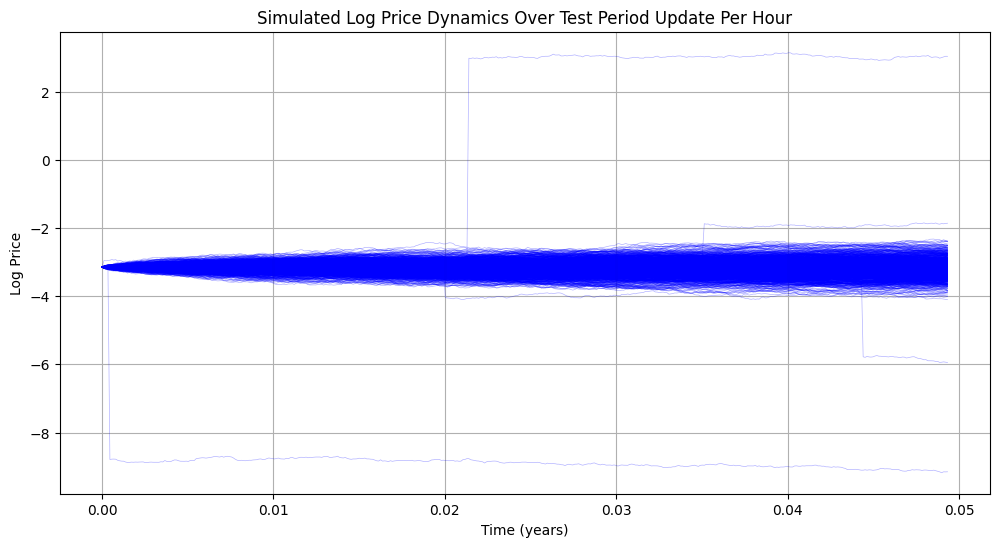

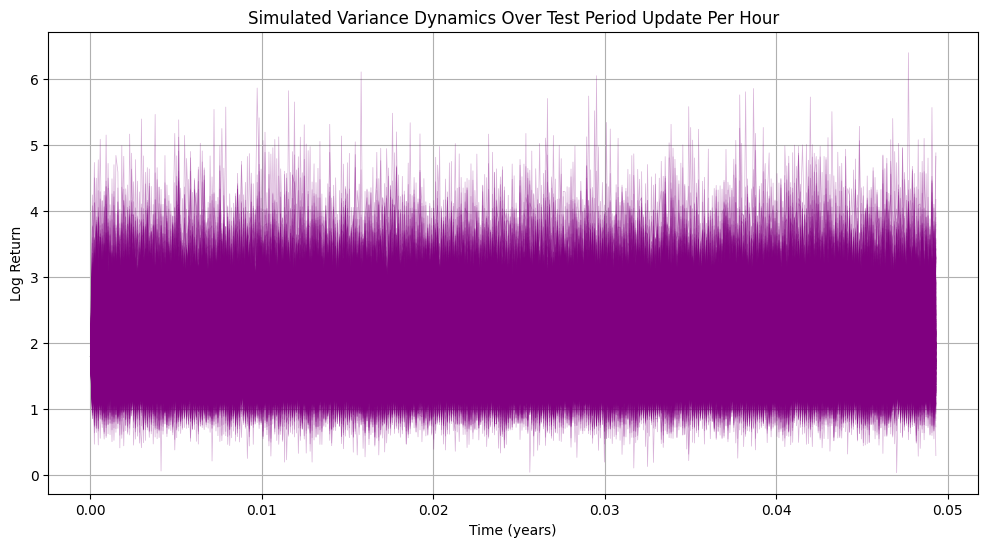

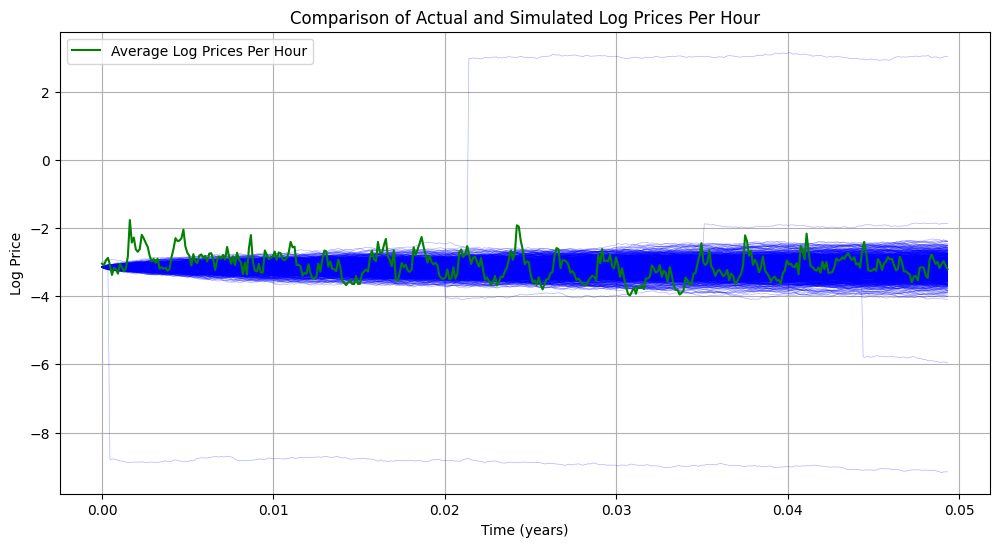

In [28]:
##################################
## MEV Path Analysis 300 Slots ##
##################################
# Plotting the results for all the paths
plt.figure(figsize=(12, 6))
for path in range(S.shape[1]):  # S.shape[1] gives the number of paths
    plt.plot(np.linspace(0, T, N), S[:, path], lw=0.5, alpha=0.3, color='blue')
plt.title('Simulated Log Price Dynamics Over Test Period Update Per Hour')
plt.xlabel('Time (years)')
plt.ylabel('Log Price')
plt.grid(True)
plt.show()

# Plotting the results for all the paths
plt.figure(figsize=(12, 6))
for path in range(v.shape[1]):  # S.shape[1] gives the number of paths
    plt.plot(np.linspace(0, T, N), v[:, path], lw=0.5, alpha=0.3, color='purple')
plt.title('Simulated Variance Dynamics Over Test Period Update Per Hour')
plt.xlabel('Time (years)')
plt.ylabel('Log Return')
plt.grid(True)
plt.show()

# Average log prices over fixed intervals
epoch_prices = np.array([np.mean(log_prices_test[i:i+300]) for i in range(0, len(log_prices_test), 300)])
total_epochs = len(epoch_prices)

# Mean of all paths
mean_S = np.mean(S, axis=1)
median_S = np.median(S, axis=1)
plt.figure(figsize=(12, 6))

# Time arrays for plotting
simulated_times = np.linspace(0, T, N)
actual_times = np.linspace(0, T, total_epochs)

# Plot simulated data
for path in range(S.shape[1]):  # S.shape[1] gives the number of paths
    plt.plot(np.linspace(0, T, N), S[:, path], lw=0.5, alpha=0.3, color='blue')
plt.plot(actual_times, epoch_prices, label='Average Log Prices Per Hour', color='green')
# Finalizing the plot
plt.title('Comparison of Actual and Simulated Log Prices Per Hour')
plt.xlabel('Time (years)')
plt.ylabel('Log Price')
plt.grid(True)
plt.legend()
plt.show()

In [29]:
# Calculate RMSE & MAE between the actual epoch prices and the simulated mean prices
mean_S = np.mean(S, axis=1)
simulated_epoch_prices = mean_S[:total_epochs]
# Calculate RMSE between the actual epoch prices and the simulated mean prices
rmse = np.sqrt(mean_squared_error(epoch_prices, simulated_epoch_prices))
print(f"RMSE between actual and simulated log prices: {rmse}")
# Calculate MAE between the actual epoch prices and the simulated mean prices
mae = np.mean(np.abs(epoch_prices - simulated_epoch_prices))
print(f"MAE between actual and simulated log prices: {mae}")

RMSE between actual and simulated log prices: 0.37861194438172385
MAE between actual and simulated log prices: 0.2991333231678223


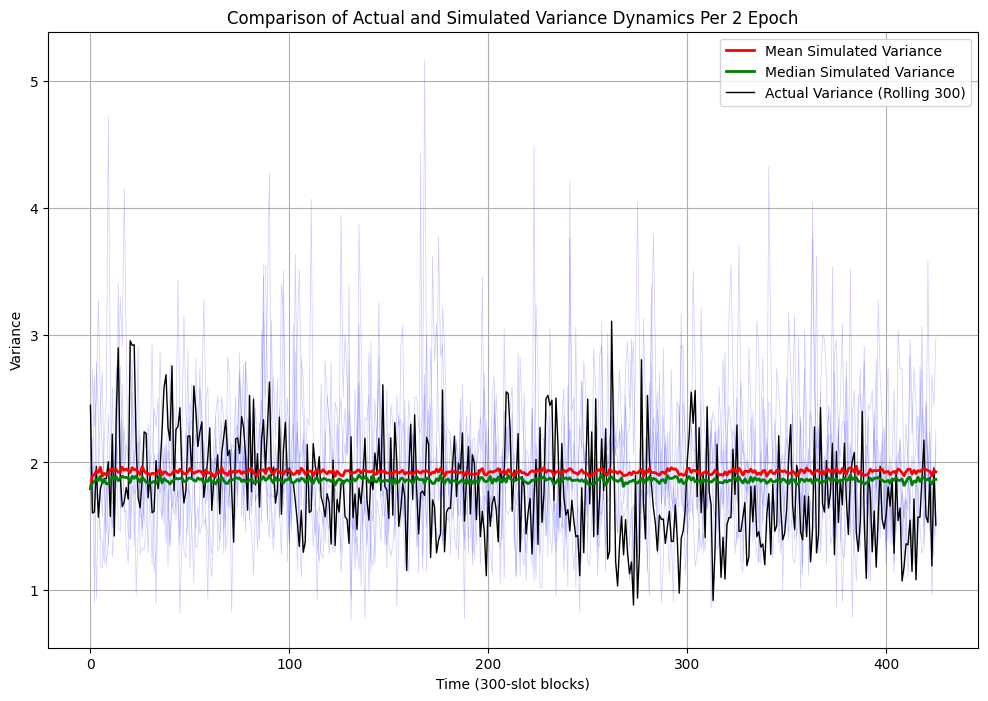

Actual number of jumps: 4
Simulated average number of jumps across paths: 10.169
Simulated median number of jumps across paths: 10.0


In [30]:
###################################################
## Variance Dynamics Analysis for 300-Slot Blocks ##
###################################################

# Simulation parameters
T = 18 / 365  # Total simulation time in years (18 days)
num_paths = 1000  # Number of Monte Carlo paths
N = 2024  # Expected number of time steps (18 days, per 2 epochs)

# Define the window size for block variance analysis
window_size = 300

# Calculate block variances using rolling windows of 300 time steps
block_variances_300blocks = [
    log_returns_test[i:i + window_size].var() 
    for i in range(0, len(log_returns_test), window_size) 
    if i + window_size <= len(log_returns_test)
]

# Convert block variances to a pandas Series for detailed analysis
actual_variance = pd.Series(block_variances_300blocks)
actual_variance_diff = actual_variance.diff().dropna()

# Adjust the simulated variance to match the actual data's length
v_truncated = v[:len(actual_variance), :]
simulated_variance_diff = np.diff(v_truncated, axis=0)

# Set the jump threshold as a multiple of the standard deviation
jump_threshold_multiplier = 2.5
actual_jump_threshold = jump_threshold_multiplier * np.std(actual_variance_diff)
simulated_jump_threshold = jump_threshold_multiplier * np.std(simulated_variance_diff, axis=0)

# Detect significant jumps in actual and simulated variance differences
actual_jumps = (np.abs(actual_variance_diff) > actual_jump_threshold).astype(int)
actual_jump_count = actual_jumps.sum()
simulated_jumps = (np.abs(simulated_variance_diff) > simulated_jump_threshold).astype(int)
simulated_jump_counts = simulated_jumps.sum(axis=0)

# Plot the dynamics of simulated variance for a selection of paths
plt.figure(figsize=(12, 8))
for path in range(min(5, num_paths)):  # Limit the number of paths plotted for better visibility
    plt.plot(v_truncated[:, path], lw=0.5, alpha=0.2, color='blue')

# Include mean and median lines of the simulated variance
mean_v_truncated = np.mean(v_truncated, axis=1)
median_v_truncated = np.median(v_truncated, axis=1)
plt.plot(mean_v_truncated, 'r', label='Mean Simulated Variance', linewidth=2, zorder=3)
plt.plot(median_v_truncated, 'g', label='Median Simulated Variance', linewidth=2, zorder=3)

# Plot the actual variance computed over 300 slots
plt.plot(actual_variance.values, 'k', label='Actual Variance (Rolling 300)', linewidth=1)
plt.title('Comparison of Actual and Simulated Variance Dynamics Per 2 Epoch')
plt.xlabel('Time (300-slot blocks)')
plt.ylabel('Variance')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Output the jump analysis results
print(f"Actual number of jumps: {actual_jump_count}")
print(f"Simulated average number of jumps across paths: {np.mean(simulated_jump_counts)}")
print(f"Simulated median number of jumps across paths: {np.median(simulated_jump_counts)}")

In [31]:
# Calculate RMSE between actual variance and mean simulated variance
mean_v_truncated = np.mean(v_truncated, axis=1)
rmse_variance = np.sqrt(mean_squared_error(actual_variance, mean_v_truncated))
print(f"RMSE between actual and simulated variance: {rmse_variance}")
mae = np.mean(np.abs(actual_variance - mean_v_truncated))
print(f"MAE between actual and simulated variance: {mae}")

RMSE between actual and simulated variance: 0.4138260475676247
MAE between actual and simulated variance: 0.3448119482367584
